In [1]:
# !pip install torch
# !pip install pandas
# !pip install numpy
# !pip install transformers
# !pip install openpyxl
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn

In [1]:
import os, warnings, torch
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
warnings.filterwarnings('ignore')

data_dir = os.path.join(os.getcwd(), "Dataset")
output_dir = os.path.join(os.getcwd(), "models", "distilbert-base-uncased_v2")

## Read in dataset

In [2]:
processed_df = pd.read_csv(os.path.join(data_dir,"emotions_processed_df.csv"))
processed_df.sample(5)

,sentiment,content
25125,happiness,cook lunch todayy givin mum relaxin dayy
21267,fun,look forward yummy dinner mizz kate jones even
27020,worry,wait line beast matthew rid
58216,fear,frighten boy bolt gooseneck side scream fishba...
34499,happiness,archnialeitl hello friend find gbw glad see tw...


In [3]:
processed_df = processed_df.rename(columns={"sentiment": "labels", "content": "text"})
processed_df.sample(5)

,labels,text
28541,worry,almost legal limit db garage
25053,love,supermouse104 hey arthur forget say thank flag...
9934,neutral,work four close
56165,happy,wind end tough rally rally feel good enough st...
4371,sadness,ceo_inthemaking aw


In [4]:
processed_df["labels"].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger', 'fear',
       'happy'], dtype=object)

In [5]:
processed_df.isnull().sum()

labels     0
text      15
dtype: int64

In [6]:
processed_df = processed_df.dropna()
processed_df.isnull().sum()

labels    0
text      0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(processed_df['labels'])
X = processed_df.iloc[:,1:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [8]:
le = LabelEncoder()
le.fit(processed_df['labels'])
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_name_mapping)

class_name = []

#print both key and value from mapping 
for key, value in le_name_mapping.items():
    print(key, value)
    class_name.append(value)

{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fear', 5: 'fun', 6: 'happiness', 7: 'happy', 8: 'hate', 9: 'love', 10: 'neutral', 11: 'relief', 12: 'sadness', 13: 'worry'}
0 anger
1 boredom
2 empty
3 enthusiasm
4 fear
5 fun
6 happiness
7 happy
8 hate
9 love
10 neutral
11 relief
12 sadness
13 worry


In [9]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [10]:
#padding and truncation of data
inputs = tokenizer(X_train['text'].tolist(), padding="max_length", truncation=True)

In [11]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = EmotionDataset(inputs, y_train)

## Model Building

In [12]:
num_labels = len(processed_df["labels"].unique())
num_labels

14

In [13]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [15]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [16]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [17]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=5000,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,              # how often to log
    save_steps = 5000,
    save_total_limit = 2
)
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

***** Running training *****
  Num examples = 46702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8757
  Number of trainable parameters = 66964238


Step,Training Loss
100,2.606800
200,2.542500
300,2.390200
400,2.257300
500,2.122700
600,2.014800
700,1.892600
800,1.790700
900,1.721800
1000,1.717900


Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8757, training_loss=1.323366774806996, metrics={'train_runtime': 1593.4766, 'train_samples_per_second': 87.925, 'train_steps_per_second': 5.496, 'total_flos': 1.856344913926963e+16, 'train_loss': 1.323366774806996, 'epoch': 3.0})

In [9]:
# Load a trained model and vocabulary that you have fine-tuned
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertForSequenceClassification, transformers.DistilBertTokenizerFast, 'distilbert-base-uncased')

model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Copy the model to the GPU.
model.to(device) 

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [10]:
def to_check_result(test_encoding):
    input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
    with torch.no_grad():
        output = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    y = np.argmax(output[0].to("cpu").numpy())
    return y

In [11]:
test_emotions = []
for i in X_test["text"]:
    test_encoding1 = tokenizer(i, padding=True, truncation=True)
    input_ids = torch.tensor(test_encoding1["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding1["attention_mask"]).to(device)
    test_emotions.append(to_check_result(test_encoding1))

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

 Accuracy 0.5761
 Precision 0.5594 
 Recall 0.5761 
 F1 0.5635

Confusion Matrix:
 [[ 561    0    0    0    7    1    2    2    4    5   13    1   24   15]
 [   0    0    0    0    0    1    4    0    3    0    9    1   11   16]
 [   0    0    0    0    1    2   15    0    6    2   81    1   11   47]
 [   0    0    0    0    0    4   38    1    3   12   60    0   11   30]
 [  17    0    0    0  457    0    1    1    0    0    1    0   11    2]
 [   0    0    0    0    0   24  122    0    4   27  100    3   18   57]
 [   1    0    0    0    0   36  492    6    4  140  208    9   41  120]
 [   0    0    0    0    3    0    5 1373    0   27    2    1    9    3]
 [   2    0    0    0    0    2   10    0   84    3   29    1   49   90]
 [   2    0    0    0    1   13  193   93    8  586   90    3   58   65]
 [   2    0    0    0    0   23  216    4   31   64  864   16  121  359]
 [   0    0    0    0    0    3   87    3    3   16   90   23   18   72]
 [  16    0    0    0   21   10   63   16

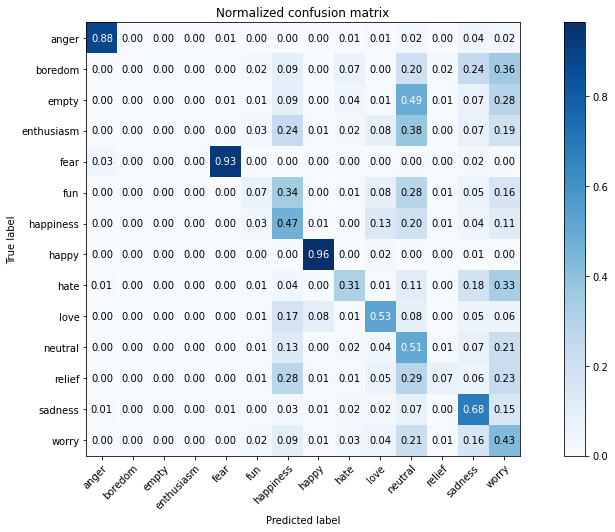

In [13]:
#checking the accuracy of the model
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
acc = round(accuracy_score(y_test, test_emotions),4)
pre = round(precision_score(y_test, test_emotions, average='weighted'),4)
rec = round(recall_score(y_test, test_emotions, average='weighted'),4)
f1 = round(f1_score(y_test, test_emotions, average='weighted'),4)

print(" Accuracy", acc)
print(" Precision",pre,"\n","Recall",rec,"\n","F1",f1)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_emotions))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, test_emotions, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [21]:
model_dir = 'distilbert-base-uncased_v2/'
output_dir = './model_save/'+model_dir

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Configuration saved in ./model_save/distilbert-base-uncased_v2/config.json


Saving model to ./model_save/distilbert-base-uncased_v2/


Model weights saved in ./model_save/distilbert-base-uncased_v2/pytorch_model.bin
tokenizer config file saved in ./model_save/distilbert-base-uncased_v2/tokenizer_config.json
Special tokens file saved in ./model_save/distilbert-base-uncased_v2/special_tokens_map.json


('./model_save/distilbert-base-uncased_v2/tokenizer_config.json',
 './model_save/distilbert-base-uncased_v2/special_tokens_map.json',
 './model_save/distilbert-base-uncased_v2/vocab.txt',
 './model_save/distilbert-base-uncased_v2/added_tokens.json',
 './model_save/distilbert-base-uncased_v2/tokenizer.json')

In [53]:
import gc
torch.cuda.empty_cache()
gc.collect()

0